<a href="https://colab.research.google.com/github/hamednasr/TensorFlow-Projects/blob/main/Food_Vision_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 101 Food Vision Classification
### classification of food dataset with over 100000 food images into 101 differenet kinds of foods! 

## import libraries:

In [81]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , accuracy_score
import numpy as np

## checking the GPU to see if it supports mixed precision

In [2]:
!nvidia-smi

Sat Aug 27 05:22:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [34]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-27 05:43:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-27 05:43:14 (87.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [35]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys 

## Tensorflow Datasets

In [ ]:
dataset_list = tfds.list_builders()
dataset_list [:10]

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence']

## importing food 101 dataset

In [4]:
(train_data,test_data), ds_info = tfds.load('food101',
                                            split=['train','validation'],
                                            shuffle_files=True,
                                            as_supervised=True,
                                            with_info=True,
                                            batch_size=32)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete9OXS37/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete9OXS37/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [5]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [6]:
len(train_data), len(test_data)

(2368, 790)

In [7]:
for images , labels in test_data:
  print(images.shape, labels)
  break

(32, 512, 512, 3) tf.Tensor(
[93 83 98 40 60 13 36 92 21 25 29 81 66 81  1 92 83 80 45 28 23 30 72 45
 94 92 46 18 99 75 16 40], shape=(32,), dtype=int64)


(512, 512, 3) <dtype: 'uint8'>


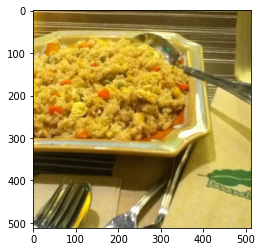

In [8]:
for image , label in test_data.take(1):
  img = image[0]
  print(img.shape, img.dtype)
  # print(tf.reduce_max(img))
  # img = tf.image.rot90(img, k=1)
  plt.imshow(img)


In [9]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='~/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo

In [10]:
ds_info.supervised_keys

('image', 'label')

In [11]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [12]:
ds_info.features['image']

Image(shape=(None, None, 3), dtype=tf.uint8)

In [13]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [14]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [15]:
# def preprocess_img(image, image_size = 224):
#   new_image = tf.image.Resize(image, size= (image_size, image_size))
#   tf.cast(new_image, dtype = tf.float32)
#   return new_image 

In [16]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [17]:
train_data.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [18]:
for image , label in train_data.take(1):
  print(f'''shape: {image.shape}
  tyep: {image.dtype}
  label : {label}''')
  #class name : {class_names[label.numpy()]}''')

shape: (32, 512, 512, 3)
  tyep: <dtype: 'uint8'>
  label : [ 23  84  44  84  34  11  61  19  67  61  30  79  46  21  89  24  77  77
   0 100  54  83  23  95   9  45   6   5  54  70  85  92]


In [19]:
image[0]

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[189, 165, 121],
        [185, 161, 117],
        [181, 157, 113],
        ...,
        [111,  72,  33],
        [103,  64,  25],
        [ 94,  55,  16]],

       [[186, 162, 118],
        [183, 159, 115],
        [180, 156, 112],
        ...,
        [122,  83,  40],
        [113,  74,  31],
        [105,  66,  23]],

       [[180, 156, 112],
        [178, 154, 110],
        [177, 153, 109],
        ...,
        [132,  94,  45],
        [124,  87,  35],
        [120,  83,  31]],

       ...,

       [[207, 204, 159],
        [205, 201, 154],
        [204, 196, 147],
        ...,
        [231, 225, 191],
        [231, 225, 189],
        [231, 226, 188]],

       [[207, 204, 159],
        [205, 201, 154],
        [204, 196, 147],
        ...,
        [230, 224, 190],
        [230, 224, 188],
        [229, 223, 187]],

       [[206, 203, 158],
        [204, 200, 153],
        [203, 195, 146],
        ...,
        [229, 223, 18

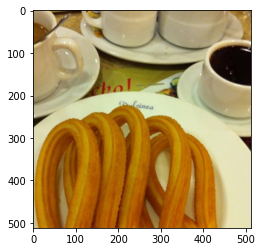

In [20]:
plt.imshow(image[0])

In [21]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [22]:
# Make a function for preprocessing images
# def preprocess_img(image, label, img_shape=224):
#   """
#   Converts image datatype from 'uint8' -> 'float32' and reshapes image to
#   [img_shape, img_shape, color_channels]
#   """
#   image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
#   return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [23]:
# train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [24]:
train_data = train_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## data augmentation

In [25]:
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.Resizing(224,224),
                    # tf.keras.layers.Rescaling(1/255), # efficientnet has built-in rescaling
                    tf.keras.layers.RandomFlip('horizontal'),
                    tf.keras.layers.RandomRotation(0.1)],
                    # tf.keras.layers.RandomZoom(0.2),
                    # tf.keras.layers.RandomHeight(0.2),
                    # tf.keras.layers.RandomWidth(0.2)], 
                    name ="data_augmentation")

## Model Callbacks

In [26]:
checkpointPath = './checkpoints/feature-extract'
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(checkpointPath, 
                                                     monitor='val_accuracy', 
                                                     save_best_only=True,
                                                     save_weights_only=True)

## Turn on Mixed Precision mode
to take advantage of GPU acceleration even more

In [27]:
mixed_precision.set_global_policy('mixed_float16')

In [28]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Model Creation

In [29]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False, pooling='avg')
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3), name = 'input_layer')

x = data_augmentation(inputs)

x = base_model(x , training =False)

x =  tf.keras.layers.Dense(101)(x)

outputs = tf.keras.layers.Activation('softmax', dtype = tf.float32, name = 'softmax_float32')(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf .keras. optimizers.Adam(),
              metrics = ['accuracy'])

16719872/16705208 [==============================] - 0s 0us/step


In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [31]:
for layer in model.layers:
  print(layer.name, layer.dtype , layer.dtype_policy)

input_layer float32 <Policy "float32">
data_augmentation float32 <Policy "float32">
efficientnetb0 float32 <Policy "mixed_float16">
dense float32 <Policy "mixed_float16">
softmax_float32 float32 <Policy "float32">


## Feature Extraction Model Training

In [32]:
# !rm -rf './tensorboard'

In [36]:
history_featureEx = model.fit(train_data, 
                    epochs = 5,
                    validation_data=test_data,
                    validation_steps=20,
                    callbacks = [create_tensorboard_callback('tensorboard','featureEx'),modelCheckpoint])

Saving TensorBoard log files to: tensorboard/featureEx/20220827-054346
Epoch 1/5
2368/2368 [==============================] - 197s 76ms/step - loss: 2.0254 - accuracy: 0.5095 - val_loss: 1.3295 - val_accuracy: 0.6500
Epoch 2/5
2368/2368 [==============================] - 174s 73ms/step - loss: 1.5156 - accuracy: 0.6137 - val_loss: 1.2406 - val_accuracy: 0.6609
Epoch 3/5
2368/2368 [==============================] - 175s 74ms/step - loss: 1.3840 - accuracy: 0.6415 - val_loss: 1.2286 - val_accuracy: 0.6703
Epoch 4/5
2368/2368 [==============================] - 173s 73ms/step - loss: 1.2961 - accuracy: 0.6636 - val_loss: 1.2447 - val_accuracy: 0.6516
Epoch 5/5
2368/2368 [==============================] - 175s 74ms/step - loss: 1.2422 - accuracy: 0.6743 - val_loss: 1.1954 - val_accuracy: 0.6672


## Model Evaluation

In [37]:
model.evaluate(test_data)

790/790 [==============================] - 59s 75ms/step - loss: 1.1505 - accuracy: 0.6862


[1.150470495223999, 0.6862178444862366]

## Save and Load the model

In [38]:
model.save('model.h5')

In [41]:
finetune_model = tf.keras.models.load_model('model.h5')

In [42]:
finetune_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [43]:
for layer in finetune_model.layers[2].layers:
  print(layer.name, layer.dtype, layer.dtype_policy)

input_1 float32 <Policy "float32">
rescaling float32 <Policy "mixed_float16">
normalization float32 <Policy "mixed_float16">
stem_conv_pad float32 <Policy "mixed_float16">
stem_conv float32 <Policy "mixed_float16">
stem_bn float32 <Policy "mixed_float16">
stem_activation float32 <Policy "mixed_float16">
block1a_dwconv float32 <Policy "mixed_float16">
block1a_bn float32 <Policy "mixed_float16">
block1a_activation float32 <Policy "mixed_float16">
block1a_se_squeeze float32 <Policy "mixed_float16">
block1a_se_reshape float32 <Policy "mixed_float16">
block1a_se_reduce float32 <Policy "mixed_float16">
block1a_se_expand float32 <Policy "mixed_float16">
block1a_se_excite float32 <Policy "mixed_float16">
block1a_project_conv float32 <Policy "mixed_float16">
block1a_project_bn float32 <Policy "mixed_float16">
block2a_expand_conv float32 <Policy "mixed_float16">
block2a_expand_bn float32 <Policy "mixed_float16">
block2a_expand_activation float32 <Policy "mixed_float16">
block2a_dwconv_pad float3

In [44]:
finetune_model.evaluate(test_data)

790/790 [==============================] - 58s 72ms/step - loss: 1.1505 - accuracy: 0.6862


[1.1505277156829834, 0.6862178444862366]

## Fine-tuning Training 
Unfreezing 30 last layers of the model

In [45]:
for layer in finetune_model.layers[2].layers[-30:]:
  layer.trainable = True

In [46]:
for layer in finetune_model.layers[2].layers:
  print(layer.name , layer.trainable)

input_1 True
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False
bloc

In [47]:
for layer in finetune_model.layers:
  print(layer.name , layer.dtype_policy)

input_layer <Policy "float32">
data_augmentation <Policy "mixed_float16">
efficientnetb0 <Policy "mixed_float16">
dense <Policy "mixed_float16">
softmax_float32 <Policy "float32">


## Earlystopping & Checkpoint Callbacks for Fine-tuning 

In [55]:
modelEarlyStopping = tf.keras.callbacks.EarlyStopping(
                                                      monitor='val_accuracy',
                                                      min_delta=0.0001,
                                                      patience=5,
                                                      verbose=1,
                                                      mode='min'
                                                      )

In [49]:
checkpointPath = './checkpoint/fine-tune'
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
                                                  checkpointPath,
                                                  monitor='val_loss',
                                                  verbose=0,
                                                  save_best_only=True,
                                                  save_weights_only=True,
                                                    )   

## Compile and Train Fine tune model

In [51]:
finetune_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                    metrics = ['accuracy'])

In [52]:
finetune_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 1,623,237
Non-train

In [61]:
history_finetune = finetune_model.fit(train_data,
                                      epochs= 100,
                                      validation_data = test_data,
                                      validation_steps = int(0.10*len(test_data)),
                                      callbacks = [create_tensorboard_callback('tensorboard','finetune'),
                                                 modelCheckpoint,
                                                 modelEarlyStopping])

Saving TensorBoard log files to: tensorboard/finetune/20220827-061024
Epoch 1/100
2368/2368 [==============================] - 205s 83ms/step - loss: 1.0839 - accuracy: 0.7122 - val_loss: 1.0213 - val_accuracy: 0.7267
Epoch 2/100
2368/2368 [==============================] - 193s 81ms/step - loss: 0.9181 - accuracy: 0.7514 - val_loss: 0.9849 - val_accuracy: 0.7334
Epoch 3/100
2368/2368 [==============================] - 189s 80ms/step - loss: 0.7948 - accuracy: 0.7818 - val_loss: 0.9632 - val_accuracy: 0.7421
Epoch 4/100
2368/2368 [==============================] - 194s 82ms/step - loss: 0.6951 - accuracy: 0.8069 - val_loss: 0.9865 - val_accuracy: 0.7401
Epoch 5/100
2368/2368 [==============================] - 187s 79ms/step - loss: 0.6068 - accuracy: 0.8293 - val_loss: 1.0016 - val_accuracy: 0.7449
Epoch 6/100
2368/2368 [==============================] - 188s 79ms/step - loss: 0.5230 - accuracy: 0.8524 - val_loss: 1.0353 - val_accuracy: 0.7445
Epoch 6: early stopping
